# Reference:

https://www.tensorflow.org/tutorials/images/transfer_learning

# Transfer Learning (Pre-Trained Model)

One of the solutions that we can try in order to have a good model without the need to train our own model for a really long time is to use a pre-trained model using transfer learning. A pre-trained model is basically a model that has been structured, trained, and tested using different kind of big dataset thus the model is robust enough to be directly used. A pre-trained model can be simply loaded to a project and get fine-tuned or trained again using the available dataset in order to adjust its knowledge to the dataset that we are working on. In this case, we will utilize the MobileNetV2 pre-trained model to help us in getting better accuracy with less amount of training efforts needed.

In [ ]:
# Load the required libraries
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# A pre-trained model usually comes with pre-defined format of dataset that is suitable for the model.
# In this case, MobileNetV2 has some size options that we can choose from and in this case we will go with 128x128 size of image
# By that, we will load the dataset again but now, we will use different size of data. The other process is the same as the one that we have worked on before.
x_train_dataset = list()

for name in image_name:
  image_data = image.imread('Train/' + name)
  image_data = tf.cast(image_data, tf.float32)/255
  image_data = tf.image.resize(image_data, (128, 128), method= 'bilinear')
  x_train_dataset.append(image_data)
train_data = np.array(x_train_dataset)

y_train_np = np.array(label)
train_labels = to_categorical(y_train_np)

In [ ]:
# Remember to split the data into 80-20 train-validation dataset so we can know how the model perform later on
x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

In [ ]:
# Let's the load the pre-trained model. We will utilize our own classification layer (Dense(200)) so we need to exclude the top layer of the pre-trained model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Since we wanted to utilize the weights that have been embedded into the pre-trained model to help us in getting higher accuracy with less training,
# we will need to ensure that we prevent the model from updating its weight when data was fit into the model. The pre-trained model later on will be
# a part of the sequential layer so the layers that will be trained later on will be the extra layers that we add such as the Dense or pooling layer
# while the layers that have been embedded into the pre-trained model must be not changed at all.
base_model.trainable = False

In [ ]:
# Here's how the pre-trained model was structured
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# We have seen on data augmentation helped our model to be better so let's try to add data augmentation into our model again.
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)
])

In [ ]:
# Then let's initiate our model. We will first initiate the input layers where it will take the numpy array with the size as defined
inputs = tf.keras.Input(shape=(128, 128, 3))

# We will then augment the image data using the augmentation layers that we have defined above
augmented_data = data_augmentation(inputs)

# Fit the augmented data to be processed by the pre-trained model which is MobileNetV2
pretrained_data = base_model(augmented_data, training=False)

# Take the average values of the data using average pooling
pooled_data = tf.keras.layers.GlobalAveragePooling2D()(pretrained_data)

# Just in case the model starts to overfit because of the small amount of data, let's surpress it a bit using dropout layer
dropped_data = Dropout(0.4)(pooled_data)

# Then finally we will dense everything to 200 outputs using softmax and some regularizers as we experimented before.
outputs = Dense(200, activation = 'softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dropped_data)

# Make the model to flow from the inputs layer to the output layer
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 200)               2562

In [ ]:
# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[TopKCategoricalAccuracy(k=1)])

In [ ]:
# and train the model to adjust some of the layers to fit the data that we are working on.
# we will use less epochs as the model has been pre-trained before so we only need to adjust some weights only
history = model.fit(x_train, y_train, epochs = 16, validation_data = (x_validation, y_validation))

Epoch 1/16
121/121 [==============================] - 9s 49ms/step - loss: 7.6096 - top_k_categorical_accuracy: 0.0549 - val_loss: 6.0017 - val_top_k_categorical_accuracy: 0.1770
Epoch 2/16
121/121 [==============================] - 5s 40ms/step - loss: 5.5120 - top_k_categorical_accuracy: 0.2250 - val_loss: 5.1829 - val_top_k_categorical_accuracy: 0.2671
Epoch 3/16
121/121 [==============================] - 5s 40ms/step - loss: 4.6418 - top_k_categorical_accuracy: 0.3238 - val_loss: 4.7103 - val_top_k_categorical_accuracy: 0.2857
Epoch 4/16
121/121 [==============================] - 5s 40ms/step - loss: 4.1759 - top_k_categorical_accuracy: 0.3919 - val_loss: 4.4713 - val_top_k_categorical_accuracy: 0.2971
Epoch 5/16
121/121 [==============================] - 5s 39ms/step - loss: 3.8499 - top_k_categorical_accuracy: 0.4320 - val_loss: 4.2544 - val_top_k_categorical_accuracy: 0.3416
Epoch 6/16
121/121 [==============================] - 5s 39ms/step - loss: 3.6490 - top_k_categorical_acc

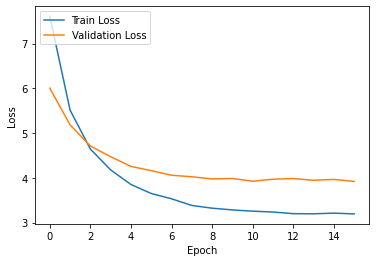

In [ ]:
# Check the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

We can see that there is not increment happened to the validation loss and the gap between the validation loss and the training loss is also not that big, indicating that the model is not overfitting. The Top-1 Accuracy of the model is also higher comparing to the other models that we have seen before, this pre-trained model is the best one so far as it is not overfitting and the Top-1 Accuracy is higher than the other ones. Some models that we have seen might score 90% of Top-1 Accuracy but then the model is overfitting so we cannot count them in. **We will go with this latest model at the end.**

In [ ]:
model.save("/content/drive/MyDrive/AML")